In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np 
from pathlib import Path

import pandas as pd 

import hippo
from hippo.agents import HierarchicalAgent, AgentModes, load_hippo_agent, load_prefrontal_agent
from hippo.environments.action_perception import action_perception_loop
from hippo.environments.w_maze import get_wmaze, WmazeTasks

import matplotlib.pyplot as plt
from scipy.stats import ttest_ind 

import random 

In [4]:
store_path = Path(hippo.__file__).parent.parent / "data/results/experiment-appendix-epistemic"
store_path.mkdir(exist_ok=True, parents=True)

def to_dataframe(logs, control_mode, agent_name, trial, goal=None):
    d_new = {
        "trial": [trial for _ in range(len(logs["action"]))],
        "agent_name": [agent_name for _ in range(len(logs["action"]))],
        "control_mode": [control_mode for _ in range(len(logs["action"]))],
        "time": np.arange(len(logs["action"])),
        "action": logs["action"],
        "reward": 1.0 * logs["reward"],
        "pos_x": [pose[0] for pose in logs["pose"]],
        "pos_y": [pose[1] for pose in logs["pose"]],
        "pos_dir": [pose[2] for pose in logs["pose"]],
        "rules": logs["rules"],
        "inbound": logs["inbound"],
        "qs_pfc": [lo.get('qs', None) for lo in logs['agent_info']]
    }
    if goal is not None: 
        d_new.update({
            "goal_reached": [np.all(p == goal) for p in logs['pose']], 
            "goal_x": [goal[0] for _ in range(len(logs['action']))],
            "goal_y": [goal[1] for _ in range(len(logs['action']))],
            "goal_dir": [goal[2] for _ in range(len(logs['action']))],
        })
    return pd.DataFrame.from_dict(d_new)

In [24]:
n_resets = 0
def reset_callback(agent, env_info):
    global n_resets
    """
    reset the agent's navigation in 2/3 chances when entering a corridor
    """
    if (env_info['pose'][1] == 3 and env_info['pose'][2] == 3):
        if np.random.randint(3) < 1: 
            agent.reset()
            n_resets += 1

def run_experiment(
        agent_mode, store_path, epistemic, n_steps=150, n_trials=5
    ):
    global n_resets
    """
    Runs the action control loop for an agent for multiple trials. 
    A control and disruption scenario is ran and the metrics are stored
    unless the agent is random (does not use state to select action) 
    """
    run_logs_df = pd.DataFrame()
    for trial in range(n_trials):
        control_key = "control"

        np.random.seed(trial)
        random.seed(trial)

        model_hippo = load_hippo_agent()
        model_pf = load_prefrontal_agent(agent_mode=agent_mode)

        model_hippo.use_epistemic = epistemic
        model_pf.agent.use_states_info_gain = epistemic
        agent = HierarchicalAgent(
            model_pf=model_pf,
            model_hippo=model_hippo,
            fe_threshold=-14.8,
            name=agent_mode.name,
        )
        agent.reset()

        run_logs = action_perception_loop(
            get_wmaze(
                task_mode=WmazeTasks.TASK0,
                cycle_rules_every=n_steps, 
                cycle_rules_random=False,
                n_rules=1,
            ),
            agent,
            n_steps,
            record_frames=False,
            record_agent_info=True,
            observable_reward=True,
            callbacks=[reset_callback],
            observable_light=False,
            progress_bar=True
        )
        print(n_resets, "resets in this trial")
        n_resets = 0

        df = to_dataframe(run_logs, control_key, agent.name, trial)
        run_logs_df = pd.concat([run_logs_df, df])

    run_logs_df.to_csv(store_path / f"{agent_mode}_{epistemic}.csv")

n_trials = 20
ns = 300

run_experiment(
    AgentModes.CSCG_LOC_RULE0, 
    epistemic=False,
    store_path=store_path, 
    n_trials=n_trials,
    n_steps=ns
)

run_experiment(
    AgentModes.CSCG_LOC_RULE0, 
    epistemic=True,
    store_path=store_path, 
    n_trials=n_trials,
    n_steps=ns
)

/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

11 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

7 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

7 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

10 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

7 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

2 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

7 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

13 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

5 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

10 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

12 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

9 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

10 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

10 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

5 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

10 resets in this trial


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

7 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

7 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

4 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

9 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

5 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

16 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

13 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

8 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

13 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

9 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

5 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


  0%|          | 0/300 [00:00<?, ?it/s]

6 resets in this trial


Epistemic...
23.480844710844714 0.6304301784816491
Utility...
26.31602071131483 0.5066028596446553


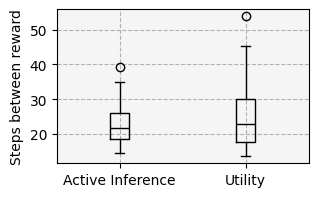

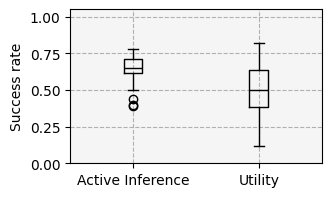

11.0 9.5


<Figure size 640x480 with 0 Axes>

inbetween time EPI vs UTI t-test
T-test:  TtestResult(statistic=-0.9511838616022888, pvalue=0.3475221366136624, df=38.0)
average success rate EPI vs UTI t-test
T-test:  TtestResult(statistic=2.557242186035472, pvalue=0.014665585437887783, df=38.0)
average summed reward EPI vs UTI t-test
T-test:  TtestResult(statistic=1.4217160742372865, pvalue=0.16326469400608823, df=38.0)


In [51]:
from hippo.visualization import format_ax
def time_inbetween_rewards(data_tot):
    inbetween = []
    rewards = []
    reward_sums= []
    for trial in np.arange(20):
        data = data_tot[data_tot['trial'] == trial]

        data = data[data["pos_y"] == 1]
        data = data[data["pos_dir"] == 3]

        rewards.append(data['reward'].mean())
        reward_sums.append(data['reward'].sum())

        data = data[data['reward'] == 1]
        times = sorted(data['time'].tolist())
        ib = []
        if len(times) > 0:
            t0 = times[0]
            for t in times[1:]:
                ib.append(t-t0)
                t0 = t

        #inbetween.extend(ib)
        if len(ib) > 0:
            inbetween.append(np.mean(ib))

    return inbetween, rewards, reward_sums


print("Epistemic...")
data = pd.read_csv(store_path / f"CSCG_LOC_RULE0_True.csv")
inb_epi, rew_epi, rew_sum_epi = time_inbetween_rewards(data)
print(np.mean(inb_epi), np.mean(rew_epi))

print("Utility...")
data = pd.read_csv(store_path / f"CSCG_LOC_RULE0_False.csv")
inb_uti, rew_uti, rew_sum_uti = time_inbetween_rewards(data)
print(np.mean(inb_uti), np.mean(rew_uti))

medianprops = dict(linestyle='-', linewidth=1.0, color='black')

fig, ax = plt.subplots(1, 1, figsize=(6.5/2, 2))
format_ax(ax)
ax.boxplot([inb_epi, inb_uti], medianprops=medianprops)
ax.set_ylabel("Steps between reward")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Active Inference", "Utility"])
plt.savefig(store_path / "robustness_noise_steps.svg", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6.5/2, 2))
format_ax(ax)
ax.boxplot([rew_epi, rew_uti], medianprops=medianprops)
ax.set_ylabel("Success rate")
ax.set_xticks([1, 2])
ax.set_ylim([0, 1.05])
ax.set_xticklabels(["Active Inference", "Utility"])
plt.savefig(store_path / "robustness_noise_reward.svg", bbox_inches='tight')
plt.show()

print(np.mean(rew_sum_epi), np.mean(rew_sum_uti))
# ax[2].boxplot([rew_sum_epi, rew_sum_uti], medianprops=medianprops)
# ax[2].set_ylabel("Average summed reward")
# ax[2].set_xticks([1, 2])
# ax[2].set_xticklabels(["Active Inference", "Utility"])
#plt.tight_layout()
plt.savefig(store_path / "robustness_noise.svg", bbox_inches='tight')
plt.show()

print("inbetween time EPI vs UTI t-test")
print("T-test: ", ttest_ind(inb_epi, inb_uti))
print("average success rate EPI vs UTI t-test")
print("T-test: ", ttest_ind(rew_epi, rew_uti))

print("average summed reward EPI vs UTI t-test")
print("T-test: ", ttest_ind(rew_sum_epi, rew_sum_uti))